In [1]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from torchvision.models import resnet50, resnet101

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.optim import lr_scheduler

from torchsummary import summary

import skimage
import skimage.transform

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor, Generator_loss
from models.unet import UNet
from training import fit_adversarial
from models.positional_encoding import PositionalEncodingSin

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
H = 180
W=180

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406]),
#T.Grayscale(num_output_channels=3)
])

transform2 = T.Compose([
T.Resize((H,W)),
T.ToTensor()
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
tr_split_len = 5000
vl_split_len = 1000
training_dataset = torch.utils.data.random_split(train_dataset, [tr_split_len, len(train_dataset)-tr_split_len])[0]
validation_dataset = torch.utils.data.random_split(val_dataset, [vl_split_len, len(val_dataset)-vl_split_len])[0]

In [7]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

In [8]:
def add_noise(inputs):
    noise = torch.randn_like(inputs)*0.2
    return inputs + noise

In [9]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

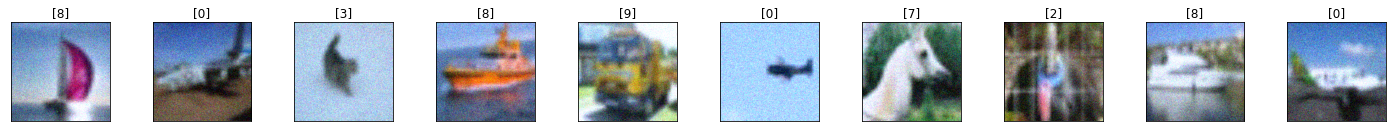

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = add_noise(images)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [11]:
cifar_img = training_dataset[4][0].unsqueeze(0)
backbone = Backbone().to(device)
encoder = EncoderModule().to(device)

In [12]:
#TESTING MODEL ON A SINGLE IMAGE

In [13]:
url = 'https://cms.qz.com/wp-content/uploads/2019/12/airplane-e1575485422322.jpg?quality=75&strip=all&w=1200&h=900&crop=1'

im = Image.open(requests.get(url, stream=True).raw)

In [14]:
img = transform2(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [15]:
noised_img = add_noise(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


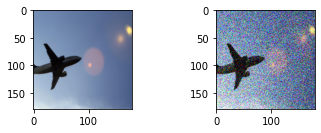

In [16]:
plt.subplot(221)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noised_img[0].detach().permute(1, 2, 0))

In [110]:
class TransConv(nn.Module):
    def __init__(self, backbone,num_classes = 10, batch_size=1, hidden_dim=512, image_h=200, image_w=200, grid_l=3, penalty_factor="1", alpha=1):
        super().__init__()
        
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.f_map_h = image_h//15 
        self.f_map_w = image_w//15

        self.dist_matrix = Attention_penalty_factor.distance_matrix(batch_size, self.f_map_w, self.f_map_h, grid_l)
        self.grids_matrix = Attention_penalty_factor.grids_matrix(batch_size, self.f_map_w, self.f_map_h, grid_l)
        self.pf_matrix = Attention_penalty_factor.penalty_factor(self.dist_matrix, penalty_factor, alpha)

        self.penalty_mask = Attention_penalty_factor.penalty_matrix(batch_size, self.f_map_w, self.f_map_h, self.grids_matrix, self.pf_matrix, grid_l)
        #self.penalty_mask = Attention_penalty_factor.penalty_mask(batch_size, self.f_map_w, self.f_map_h, grid_l, penalty_factor, alpha)

        self.conv1 = backbone.backbone.conv1
        self.bn1 = backbone.backbone.bn1
        self.relu = backbone.backbone.relu
        self.maxpool = backbone.backbone.maxpool

        self.layer1 = backbone.backbone.layer1
        self.layer2 = backbone.backbone.layer2
        self.layer3 = backbone.backbone.layer3
        #self.encoder = encoder

        self.conv2 = nn.Conv2d(1024, hidden_dim, 1)
        
        self.self_attn = nn.MultiheadAttention(embed_dim=self.hidden_dim, num_heads=8, dropout=0.05)

        
        self.conv3 = nn.Conv2d(512+144, hidden_dim, 1)
        
        self.fc1 = nn.Linear(self.hidden_dim*12*12, self.num_classes)
        #self.fc2 = nn.Linear(8192, 1024)
        #self.fc3 = nn.Linear(1024, 128)
        #self.fc4 = nn.Linear(128, 10)


    def forward(self, inputs):
        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        h = self.conv2(x)
        shape = h.shape
        pos = PositionalEncodingSin.positionalencoding2d(shape[0],self.hidden_dim,shape[2],shape[3])
        
        #h, pos = self.backbone(inputs)
        pos=pos.to(device)
        
        src = h.flatten(2).permute(2, 0, 1)
        pos_embed = pos.flatten(2).permute(2, 0, 1)
        #print(h.shape)
        q = k = src# + pos_embed
        v = src
        
        att, sattn = self.self_attn(q,k,v)

        #print(att.shape)

        x = sattn.reshape(sattn.shape[:-1] + h.shape[-2:]) 

        #sattn = sattn.reshape(sattn.shape[:-2] + h.shape[-2:] + h.shape[-2:])
        #sattn = sattn.permute(0,3,4,1,2)
        #print(sattn.shape)
        #print(h.shape)
        #print(x.shape)
        #pattn = sattn*self.penalty_mask.to(device)

        x = torch.cat([h,x],1)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = x.reshape(-1, 512 * 12 * 12)
        #print(x.shape)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        out = self.fc1(x)
        return out, sattn, h

In [111]:
model = TransConv(backbone,hidden_dim=512, image_h=H, image_w=W)
model = model.to(device)

In [124]:
out, satt, conv_features = model(img.to(device))

In [125]:
print("Output shape:", out.shape)
print("Feature Map shape:", conv_features.shape)
print("Attention Maps shape:", satt.shape)
#print("Encoder output shape:", att.shape)
#print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])
Feature Map shape: torch.Size([1, 512, 12, 12])
Attention Maps shape: torch.Size([1, 144, 144])


In [126]:
satt

tensor([[[6.8141e-08, 4.8760e-09, 5.4216e-08,  ..., 6.7696e-07,
          1.1331e-09, 1.1490e-04],
         [3.7446e-03, 3.2881e-03, 2.0789e-03,  ..., 6.7213e-04,
          1.5521e-02, 2.9159e-04],
         [2.5136e-05, 5.8456e-05, 7.1994e-06,  ..., 7.4031e-08,
          1.7122e-03, 3.1215e-09],
         ...,
         [2.9357e-08, 2.0283e-09, 3.9247e-08,  ..., 4.2352e-07,
          9.6765e-10, 5.7560e-04],
         [3.0705e-03, 5.4718e-03, 5.2874e-03,  ..., 1.8741e-03,
          1.1834e-02, 3.2537e-03],
         [2.6638e-03, 3.8004e-04, 8.8993e-04,  ..., 1.3614e-03,
          5.0354e-04, 9.9953e-03]]], device='cuda:0', grad_fn=<DivBackward0>)

In [127]:
f_map = conv_features
shape = f_map.shape[-2:]
sattn = satt.reshape(shape + shape).cpu().detach().numpy()
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: (12, 12, 12, 12)


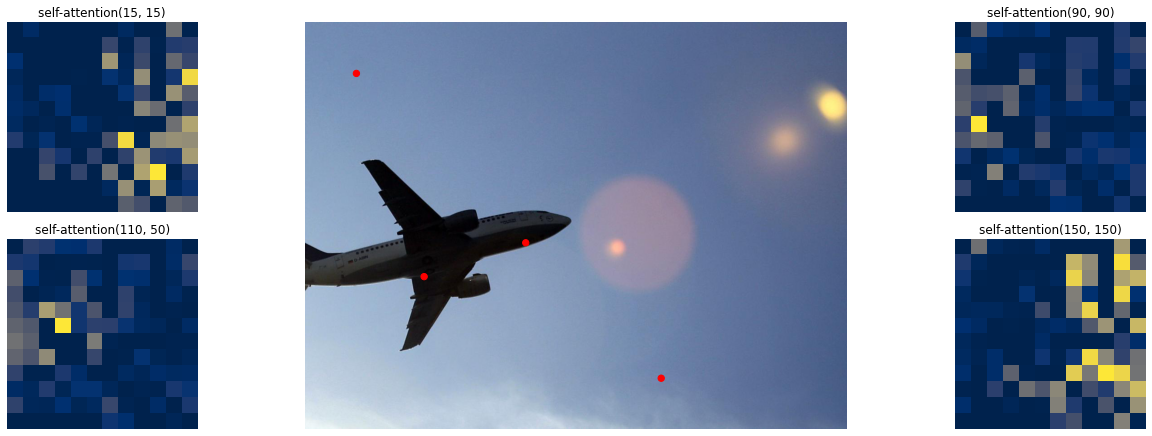

In [132]:
def plot_MHAM(sattn):
    # downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
    fact = 15

    # let's select 4 reference points for visualization
    idxs = [(15, 15), (110, 50), (90, 90), (150, 150),]

    # here we create the canvas
    fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
    # and we add one plot per reference point
    gs = fig.add_gridspec(2, 4)
    axs = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[0, -1]),
        fig.add_subplot(gs[1, -1]),
    ]

    # for each one of the reference points, let's plot the self-attention
    # for that point
    for idx_o, ax in zip(idxs, axs):
        idx = (idx_o[0] // fact, idx_o[1] // fact)
        ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
        ax.axis('off')
        ax.set_title(f'self-attention{idx_o}')

    # and now let's add the central image, with the reference points as red circles
    fcenter_ax = fig.add_subplot(gs[:, 1:-1])
    fcenter_ax.imshow(im)
    for (y, x) in idxs:
        scale = im.height / img.shape[-2]
        x = ((x // fact) + 0.5) * fact
        y = ((y // fact) + 0.5) * fact
        fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
        fcenter_ax.axis('off')
plot_MHAM(sattn)

In [117]:
#for param in model.parameters():
#    param.requires_grad = True
#    print(param.requires_grad)

In [118]:
#Training Model

In [119]:
model_criterion = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_lr_scheduler = lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=0.1)

In [120]:
def train_model_rn(model, inputs, labels, opt_d, model_criterion):
    
    
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    real_inputs = inputs.to(device) # allow gpu use
    labels = labels.to(device) # allow gpu use
    # Pass real images through model
    real_preds, sattn, fmap = model(real_inputs)
    real_loss = model_criterion(real_preds, labels)
    real_score = torch.mean(real_preds).item()
    
    _, preds = torch.max(real_preds, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
     # the sum of the loss of all itens
    running_corrects = torch.sum(preds == labels.data) # the sum of correct prediction on an epochs
    #print("TRAIN MODEL FUNCTION - RUNNING CORRECTS",running_corrects)
    
    # Generate fake images
    noised_inputs = add_noise(real_inputs)

    # Pass fake images through discriminator
    noised_preds, noised_sattn, noised_fmap = model(noised_inputs)
    noised_loss = model_criterion(noised_preds, labels)
    noised_score = torch.mean(noised_preds).item()
    
    _, preds_noised = torch.max(noised_preds, 1)
    running_noised_corrects = torch.sum(preds_noised == labels.data)
    #print("TRAIN MODEL FUNCTION - RUNNING NOISED CORRECTS",running_noised_corrects)

    # Update discriminator weights
    loss = real_loss + noised_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, noised_score, running_corrects, running_noised_corrects, sattn, noised_sattn

In [121]:
def fit_random_noise(training_loader, validation_loader, model, model_criterion, model_optimizer, 
    model_lr_scheduler, len_train, len_val, 
    path='test/TOP_PERFORMANCE_epoch_', epochs=25, start_idx=1):
    
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_d = []
    real_scores = []
    noise_scores = []
    real_corrects = []
    noised_corrects = []
    val_real_corrects = []
    val_noised_corrects = []
    train_real_attention_maps = []
    train_adversarial_attention_maps = []
    val_real_attention_maps = []
    val_adversarial_attention_maps = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        start_time = time.time()
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        
        running_loss = 0.0
        running_real_corrects = 0.0
        running_noised_corrects = 0.0
        val_running_loss = 0.0
        val_running_real_corrects = 0.0
        val_running_noised_corrects = 0.0

        
        for inputs, labels in training_loader:
            # Train discriminator
            loss_d, real_score, noise_score, real_pred, noised_pred, sattn, noised_sattn = train_model_rn(model, inputs, labels, model_optimizer, model_criterion)
            running_real_corrects +=real_pred
            running_noised_corrects +=noised_pred
            #print("FIT FUNCTION - RUNNING REAL CORRECTS",running_real_corrects.item())
            #print("FIT FUNCTION - RUNNING NOISED CORRECTS",running_noised_corrects.item())
            

        else:
        #VALIDATION
            with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
                for val_inputs, val_labels in validation_loader:
                    val_inputs = val_inputs.to(device) # allow gpu use
                    val_labels = val_labels.to(device) # allow gpu use
                    val_noised_input = add_noise(val_inputs) #passes the image through the network and get the output
                    val_preds_real, val_real_sattn, val_real_pattn = model(val_inputs)
                    val_preds_noised, val_noised_sattn, val_noised_pattn = model(val_noised_input)
                    val_real_loss = model_criterion(val_preds_real, val_labels) #compare output and labels to get the loss 
                    val_noised_loss = model_criterion(val_preds_noised, val_labels)
                    
                    _, val_real_preds = torch.max(val_preds_real, 1) #same as for training
                    _, val_noised_preds = torch.max(val_preds_noised, 1) #same as for training
                    
                    val_loss = val_real_loss + val_noised_loss
                    val_running_real_corrects += torch.sum(val_real_preds == val_labels.data) #same as for training
                    val_running_noised_corrects += torch.sum(val_noised_preds == val_labels.data) #same as for training
        
        model_lr_scheduler.step()

        # Record losses & scores
        losses_d.append(loss_d)
        real_scores.append(real_score)
        noise_scores.append(noise_score)
        real_corrects.append(running_real_corrects)
        noised_corrects.append(running_noised_corrects)
        val_real_corrects.append(val_running_real_corrects)
        val_noised_corrects.append(val_running_noised_corrects)
        train_real_attention_maps.append(sattn)
        train_adversarial_attention_maps.append(noised_sattn)
        val_real_attention_maps.append(val_real_sattn)
        val_adversarial_attention_maps.append(val_noised_sattn)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_d: {:.4f}, real_score: {:.4f}, noised_score: {:.4f}".format(
            epoch+1, epochs, loss_d, real_score, noise_score))
    
    
        # Model accuracy       
        print("EPOCH RUNNING REAL CORRECT PREDICTIONS",running_real_corrects.item())
        print("EPOCH RUNNING NOISED CORRECTS PREDICTIONS",running_noised_corrects.item())
        epoch_real_acc = running_real_corrects.item()/ len_train
        epoch_noised_acc = running_noised_corrects.item()/ len_train
        print("Epoch [{}/{}], Training - real acc: {:.4f}, noised acc: {:.4f}".format(
            epoch+1, epochs, epoch_real_acc, epoch_noised_acc))
        
        val_epoch_real_acc = val_running_real_corrects.float()/ len_val
        val_epoch_noised_acc = val_running_noised_corrects.float()/ len_val
        print("Epoch [{}/{}], Validation - real acc: {:.4f}, noised acc: {:.4f}".format(
            epoch+1, epochs, val_epoch_real_acc, val_epoch_noised_acc))
              
        # Save generated images
        #save_samples(epoch+start_idx, fixed_latent, show=False)
        
        
        epoch_time_elapsed = time.time() - start_time
        print('Epoch training complete in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))

        if val_epoch_real_acc > best_acc:
                best_acc = val_epoch_real_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print("TOP PERFORMANCE UPDATED")
        
        out, satt, conv_features = model(img.to(device))
        f_map = conv_features
        shape = f_map.shape[-2:]
        sattn = satt.reshape(shape + shape).cpu().detach().numpy()
        plot_MHAM(sattn)
                            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(),path + str(epoch) + '.pth')
    
    return losses_d, real_corrects, noised_corrects, val_real_corrects, val_noised_corrects,train_real_attention_maps, train_adversarial_attention_maps, val_real_attention_maps, val_adversarial_attention_maps

Epoch 1/10
----------
Epoch [1/10], loss_d: 0.3089, real_score: 0.0589, noised_score: 0.0630
EPOCH RUNNING REAL CORRECT PREDICTIONS 4592.0
EPOCH RUNNING NOISED CORRECTS PREDICTIONS 4547.0
Epoch [1/10], Training - real acc: 0.9184, noised acc: 0.9094
Epoch [1/10], Validation - real acc: 0.4730, noised acc: 0.4690
Epoch training complete in 1m 22s
TOP PERFORMANCE UPDATED
Epoch 2/10
----------
Epoch [2/10], loss_d: 0.1259, real_score: -0.0585, noised_score: -0.0583
EPOCH RUNNING REAL CORRECT PREDICTIONS 4771.0
EPOCH RUNNING NOISED CORRECTS PREDICTIONS 4713.0
Epoch [2/10], Training - real acc: 0.9542, noised acc: 0.9426
Epoch [2/10], Validation - real acc: 0.4650, noised acc: 0.4620
Epoch training complete in 1m 22s
Epoch 3/10
----------
Epoch [3/10], loss_d: 0.3215, real_score: -0.1524, noised_score: -0.1617
EPOCH RUNNING REAL CORRECT PREDICTIONS 4816.0
EPOCH RUNNING NOISED CORRECTS PREDICTIONS 4785.0
Epoch [3/10], Training - real acc: 0.9632, noised acc: 0.9570
Epoch [3/10], Validation -

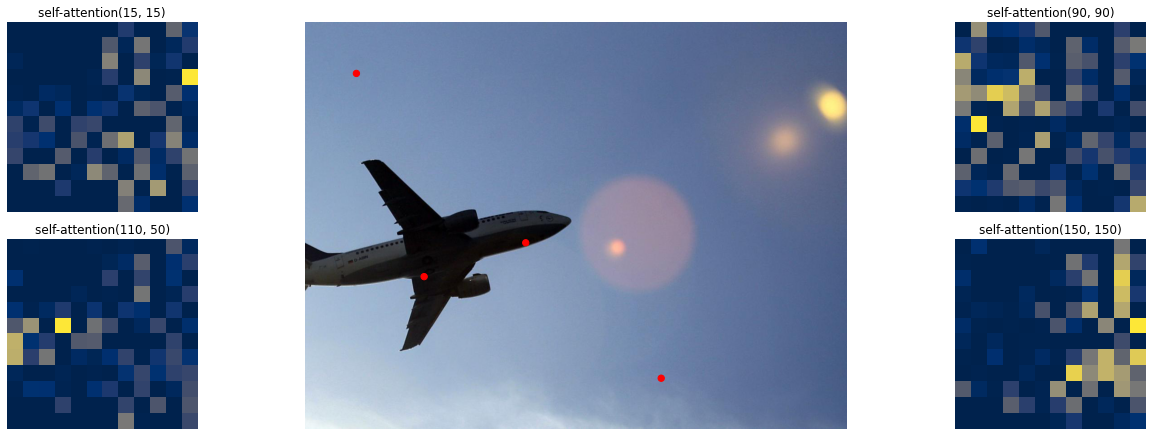

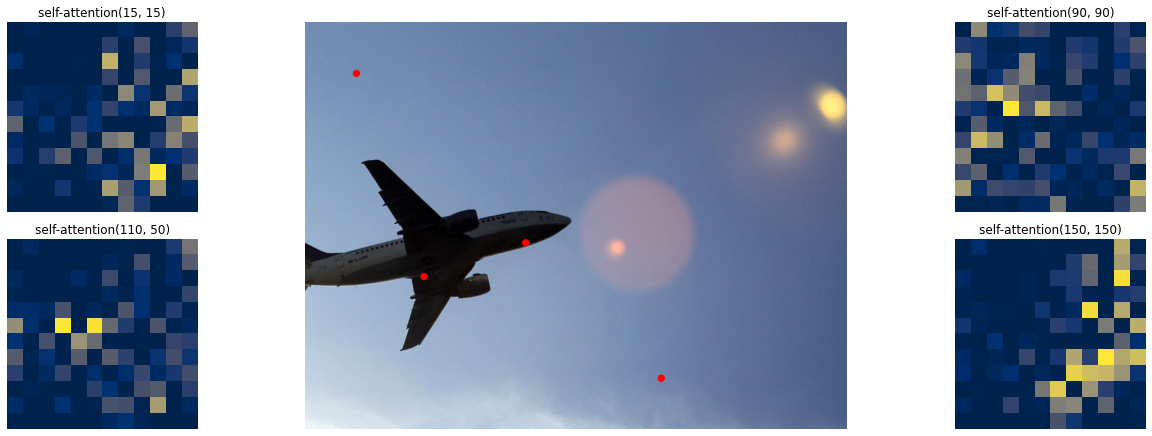

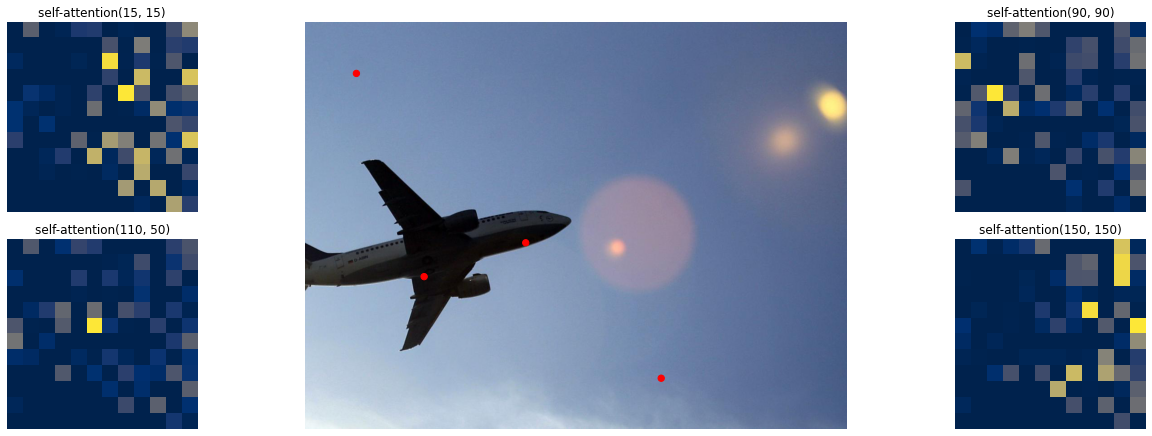

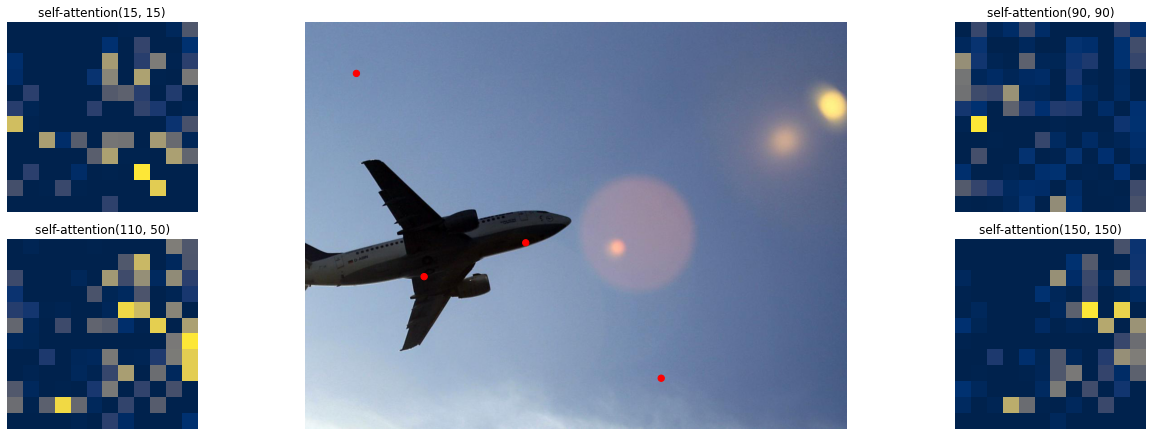

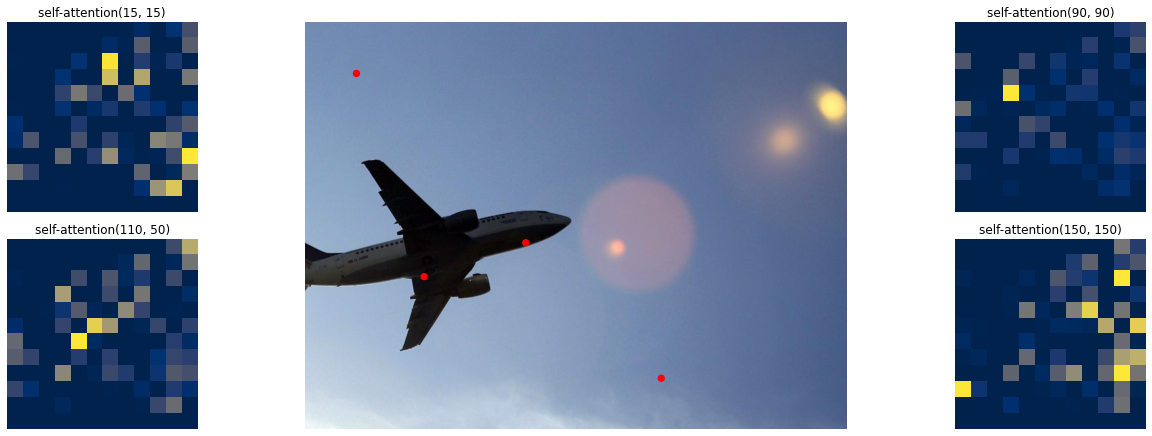

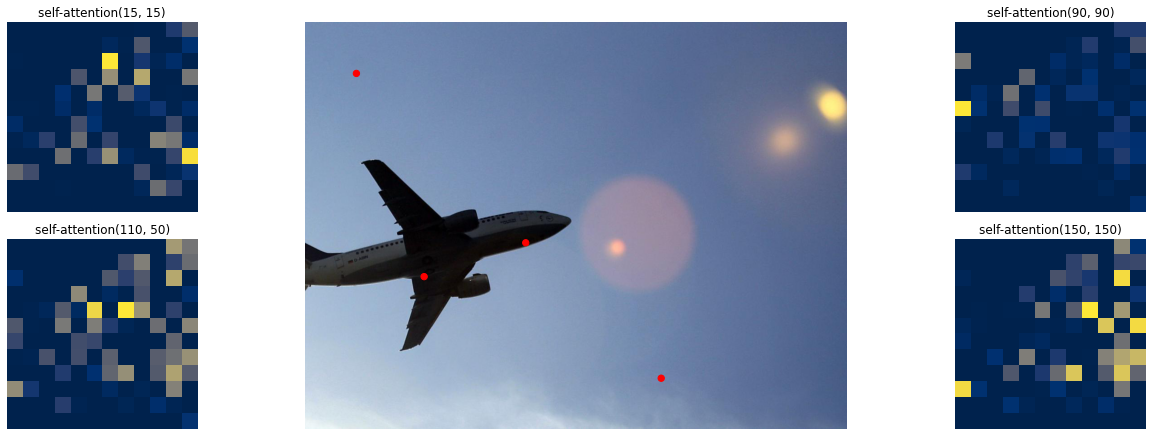

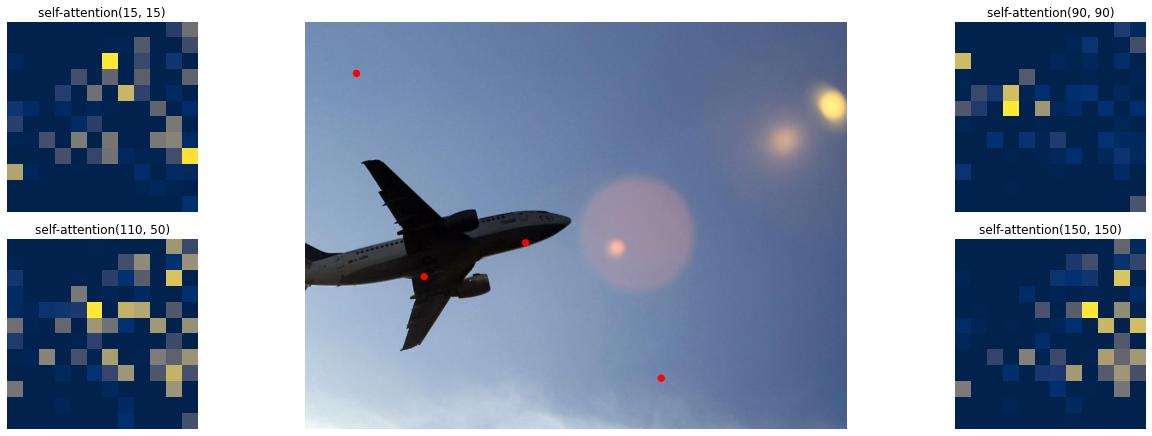

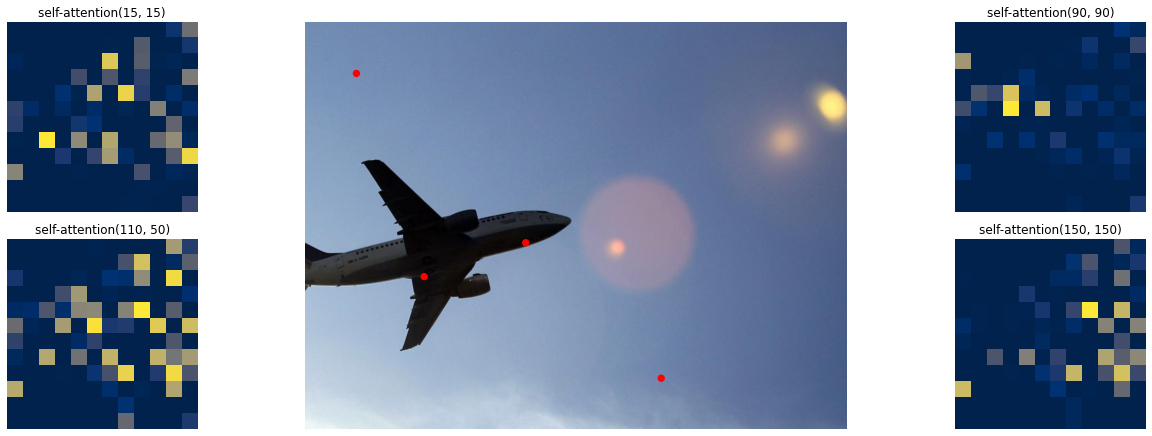

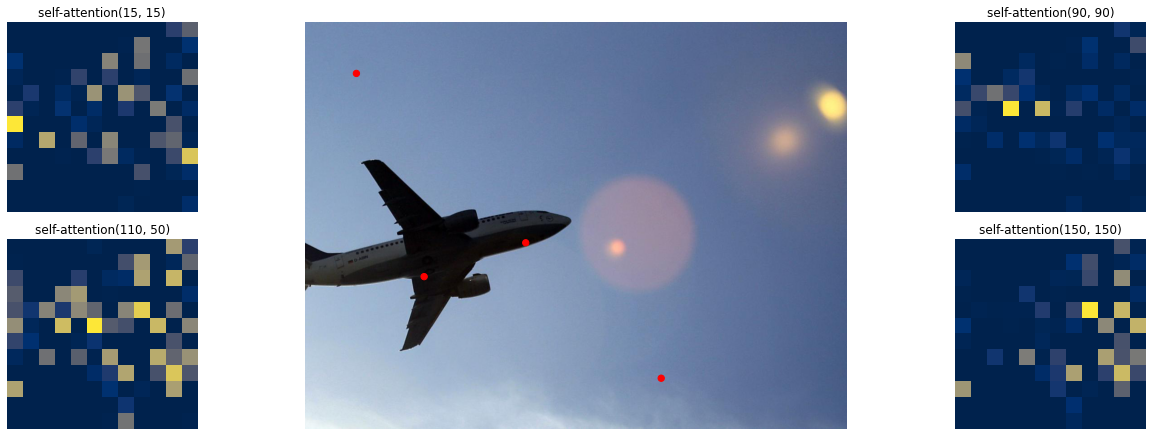

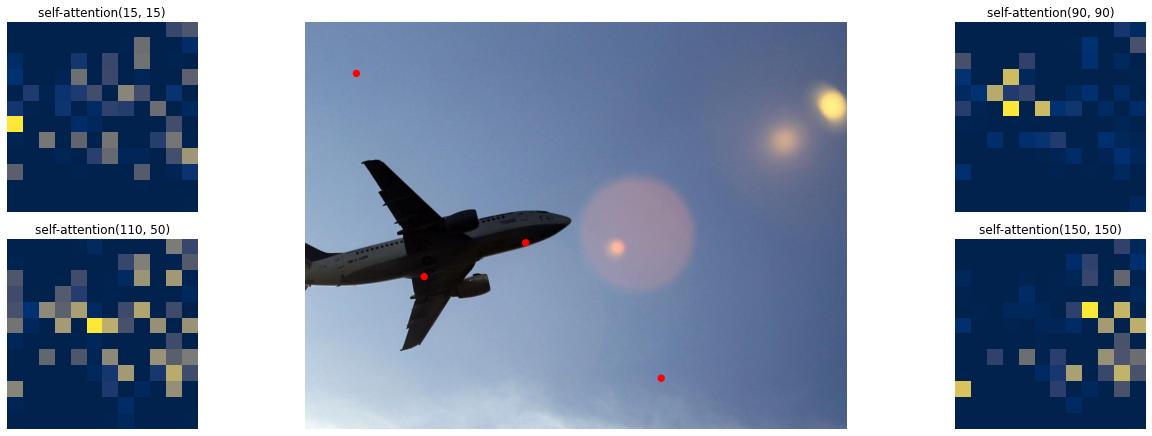

In [159]:
random_noise_training = fit_random_noise(training_loader, validation_loader, model, model_criterion, model_optimizer, 
    model_lr_scheduler, len_train=len(training_dataset), len_val=len(validation_dataset), 
    path='test/RAMDOM_NOISE_NO_BYPASS_TOP_PERFORMANCE_epoch_', epochs=10, start_idx=1)

In [133]:
real_accuracy = []
noised_accuracy = []
for i in range(len(random_noise_training[1])):
    real_accuracy.append(random_noise_training[1][i]/len(training_dataset))
    noised_accuracy.append(random_noise_training[2][i]/len(training_dataset))

In [134]:
val_real_accuracy = []
val_noised_accuracy = []
for i in range(len(random_noise_training[1])):
    val_real_accuracy.append(random_noise_training[3][i]/len(validation_dataset))
    val_noised_accuracy.append(random_noise_training[4][i]/len(validation_dataset))

In [135]:
training_accuracy = []
validation_accuracy = []
for i in range(len(random_noise_training[1])):
    training_accuracy.append((random_noise_training[1][i]+random_noise_training[2][i])/len(training_dataset)*2)
    validation_accuracy.append((random_noise_training[3][i]+random_noise_training[4][i])/len(validation_dataset)*2)

Text(0, 0.5, 'Model Loss')

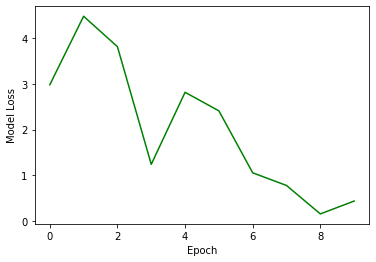

In [136]:
plt.plot()
plt.plot(random_noise_training[0],color="g")
plt.xlabel("Epoch")
plt.ylabel("Model Loss")

Text(0, 0.5, 'Training accuracy')

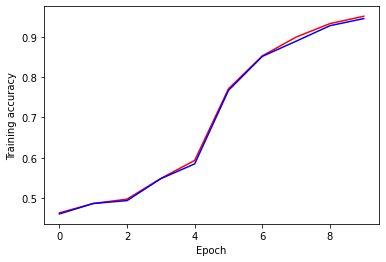

In [137]:
plt.plot()
plt.plot(real_accuracy,color="r",)
plt.plot(noised_accuracy,color="b")
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")

Text(0, 0.5, 'Validation accuracy')

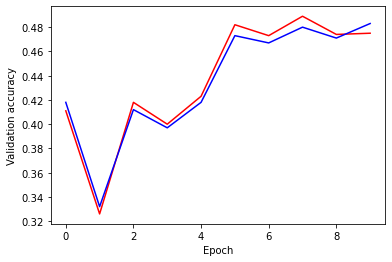

In [138]:
plt.plot()
plt.plot(val_real_accuracy,color="r",)
plt.plot(val_noised_accuracy,color="b")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")

Text(0, 0.5, 'Training vs Validation accuracy')

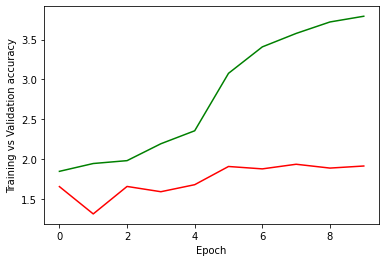

In [139]:
plt.plot()
plt.plot(training_accuracy,color="g",)
plt.plot(validation_accuracy,color="r")
plt.xlabel("Epoch")
plt.ylabel("Training vs Validation accuracy")

In [33]:
#for param in model.encoder.parameters():
#    print(param.requires_grad)

In [169]:
cifar_img = training_dataset[9][0].unsqueeze(0)
cifar_img = cifar_img.to(device)
cifar_noised = add_noise(cifar_img)
outputs2, sattn2, pattn2 = model(cifar_img)
sattn2 = sattn2.reshape(1,12,12,12,12)
outputs_noised, sattn_noised, pattn_noised = model(cifar_noised)
sattn_noised = sattn_noised.reshape(1,12,12,12,12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


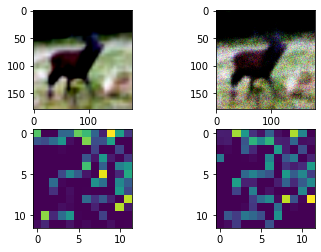

In [171]:
pix_h = 6
pix_w = 6
plt.subplot(221)
plt.imshow(cifar_img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(cifar_noised[0].cpu().detach().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(sattn2[0,...,pix_h,pix_w].cpu().detach().numpy())
plt.subplot(224)
plt.imshow(sattn_noised[0,...,pix_h,pix_w].cpu().detach().numpy())